In [1]:
from functions_for_pred import *

[nltk_data] Downloading package wordnet to /Users/daisy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/daisy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
test = pd.read_csv('data/test.csv')
X_valid = pd.read_csv('test/X_valid.csv')
y_valid = pd.read_csv('test/y_valid.csv')
X_train = pd.read_csv('test/X_train.csv')
y_train = pd.read_csv('test/y_train.csv')
test = pd.read_csv('data/test.csv')

In [85]:
X_train = X_train.drop(columns=['Unnamed: 0'])
X_valid = X_valid.drop(columns=['Unnamed: 0'])

In [86]:
## prepare for numeric values preparation
pca = pickle.load(open("model/pca.pkl", "rb"))
lda = pickle.load(open("model/lda.pkl", "rb"))
vect_col = pickle.load(open("model/vect_col.pkl", "rb"))
num_pred_col = pickle.load(open("model/numeric_train_col.pkl","rb"))

X_train = create_pca_lda_for_test(X_train, vect_col)
X_train2 = create_new_features(X_train)

X_valid = create_pca_lda_for_test(X_valid, vect_col)
X_valid2 = create_new_features(X_valid)


In [87]:
#check prediction
xgb_model_num = XGBClassifier()
xgb_model_num.load_model('model/xgb_model_num.model')

In [88]:
xgb_model_num.predict(X_valid2[num_pred_col])

array(['folk', 'folk', 'classic pop and rock', ..., 'pop',
       'dance and electronica', 'folk'], dtype='<U21')

In [89]:
## for text classifications preparation

lda_model = gensim.models.ldamulticore.LdaMulticore.load('model/lda_model.model')
train_id2word =  pickle.load(open("model/train_id2word.pkl", 'rb'))
lda_model2 = gensim.models.ldamulticore.LdaMulticore.load('model/lda_model2.model')

X_train_text_array1, y_train_text_array1 = prepare_text_for_prediction(X_train, y_train, train_id2word,lda_model)
X_train_text_array2, y_train_text_array2 = prepare_text_for_prediction(X_train, y_train, train_id2word,lda_model2)

X_text_array1, y_text_array1 = prepare_text_for_prediction(X_valid, y_valid, train_id2word,lda_model)
X_text_array2, y_text_array2 = prepare_text_for_prediction(X_valid, y_valid, train_id2word,lda_model2)

In [90]:
xgb_model_text= XGBClassifier()
xgb_model_text.load_model('model/xgb_model_text.model')

In [91]:
train_vecs=np.concatenate( [X_train_text_array1, X_train_text_array2], axis=1)

valid_vecs = np.concatenate([X_text_array1, X_text_array2], axis=1)
X_valid_vecs = np.array(valid_vecs)
text_pred = xgb_model_text.predict(X_valid_vecs)

In [92]:
expected_pred = pd.read_csv('test/valid_test_prediction.csv')

In [93]:
sum(expected_pred['pred']!=text_pred)

214

In [94]:
X_train2=X_train2.drop(columns=['text'])
X_valid2=X_valid2.drop(columns=['text'])

In [96]:
np.shape(X_train2),

((4876, 172),)

In [97]:
X_train_final = np.concatenate([train_vecs,np.array(X_train2)],axis=1)
X_valid_final = np.concatenate([valid_vecs,np.array(X_valid2)],axis=1)

In [98]:
np.shape(X_valid_final)

(3252, 190)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_valid_final , y_valid, test_size=0.5, random_state=123)


In [100]:
max_depth = [5]  #, 7
eta = [ .25] #  .1, .2,
gamma = [.25, .3] 
sampling_method = ['gradient_based']  
reg_lambda = [.15 , .2]
colsample_bytree = [ .3] #.4,
alphax = [.6] 
num_parallel_tree = [5] 
grid_para_2 = dict(max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=alphax,
                 colsample_bytree=colsample_bytree, eta=eta, gamma=gamma,
                 sampling_method=sampling_method, 
                 num_parallel_tree=num_parallel_tree)


In [101]:
def grid_search_CV(grid_para, X, y, test_X, test_y, name):

    model_1 = GridSearchCV(XGBClassifier(eval_metric='mlogloss'),
                               grid_para, cv=3)
    model_1.fit(X, y, eval_set = [(test_X, test_y)],
                early_stopping_rounds = 10)
    print(model_1.best_score_)
    print(model_1.best_params_)
    {'colsample_bytree': 0.4, 'eta': 0.15, 'gamma': 0.2, 'max_depth': 5, 'num_parallel_tree': 5, 'reg_alpha': 0.6, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}
    {'colsample_bytree': 0.4, 'eta': 0.15, 'gamma': 0.15, 'max_depth': 7, 'num_parallel_tree': 5, 'reg_alpha': 0.6, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}
    {'colsample_bytree': 0.3, 'eta': 0.2, 'gamma': 0.25, 'max_depth': 5, 'num_parallel_tree': 5, 'reg_alpha': 0.6, 'reg_lambda': 0.2, 'sampling_method': 'gradient_based'}
    {'colsample_bytree': 0.3, 'eta': 0.2, 'gamma': 0.25, 'max_depth': 5, 'num_parallel_tree': 5, 'reg_alpha': 0.6, 'reg_lambda': 0.2, 'sampling_method': 'gradient_based'}
    xgb_m = XGBClassifier(eval_metric = ['mlogloss'],
                          objective='multi:softprob',
                          booster = 'gbtree',
                          grow_policy='lossguide',
                          max_depth=model_1.best_params_['max_depth'],
                          reg_alpha=model_1.best_params_['reg_alpha'],
                          reg_lambda=model_1.best_params_['reg_lambda'],
                          eta=model_1.best_params_['eta'],
                          num_parallel_tree = model_1.best_params_['num_parallel_tree'],
                          gamma=model_1.best_params_['gamma'],
                          sampling_method=model_1.best_params_['sampling_method'],
                          colsample_bytree=model_1.best_params_['colsample_bytree'],
                          seed=123,
                          n_jobs = -1,
                            )
    xgb_m.fit(X, y)
    xgb_m.save_model('model/xgb_model_' + name + '.model')
    return xgb_m


In [102]:
xgb_model = grid_search_CV(grid_para_2, X_train_final, y_train['genre'], X_valid_1, y_valid_1['genre'],'all') #



/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82038
[1]	validation_0-mlogloss:1.66452
[2]	validation_0-mlogloss:1.54865
[3]	validation_0-mlogloss:1.46509
[4]	validation_0-mlogloss:1.39497
[5]	validation_0-mlogloss:1.33919
[6]	validation_0-mlogloss:1.29343
[7]	validation_0-mlogloss:1.25638
[8]	validation_0-mlogloss:1.22436
[9]	validation_0-mlogloss:1.19722
[10]	validation_0-mlogloss:1.17371
[11]	validation_0-mlogloss:1.15386
[12]	validation_0-mlogloss:1.13459
[13]	validation_0-mlogloss:1.12014
[14]	validation_0-mlogloss:1.10529
[15]	validation_0-mlogloss:1.09361
[16]	validation_0-mlogloss:1.08300
[17]	validation_0-mlogloss:1.07370
[18]	validation_0-mlogloss:1.06660
[19]	validation_0-mlogloss:1.05825
[20]	validation_0-mlogloss:1.05135
[21]	validation_0-mlogloss:1.04566
[22]	validation_0-mlogloss:1.03951
[23]	validation_0-mlogloss:1.03350
[24]	validation_0-mlogloss:1.02806
[25]	validation_0-mlogloss:1.02267
[26]	validation_0-mlogloss:1.01853
[27]	validation_0-mlogloss:1.01608
[28]	validation_0-mlogloss:1.0

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.66521
[2]	validation_0-mlogloss:1.54949
[3]	validation_0-mlogloss:1.46593
[4]	validation_0-mlogloss:1.39436
[5]	validation_0-mlogloss:1.33577
[6]	validation_0-mlogloss:1.29018
[7]	validation_0-mlogloss:1.25067
[8]	validation_0-mlogloss:1.21716
[9]	validation_0-mlogloss:1.19039
[10]	validation_0-mlogloss:1.16606
[11]	validation_0-mlogloss:1.14595
[12]	validation_0-mlogloss:1.12692
[13]	validation_0-mlogloss:1.11199
[14]	validation_0-mlogloss:1.09689
[15]	validation_0-mlogloss:1.08371
[16]	validation_0-mlogloss:1.07119
[17]	validation_0-mlogloss:1.06157
[18]	validation_0-mlogloss:1.05206
[19]	validation_0-mlogloss:1.04281
[20]	validation_0-mlogloss:1.03532
[21]	validation_0-mlogloss:1.02823
[22]	validation_0-mlogloss:1.02249
[23]	validation_0-mlogloss:1.01674
[24]	validation_0-mlogloss:1.01099
[25]	validation_0-mlogloss:1.00643
[26]	validation_0-mlogloss:1.00198
[27]	validation_0-mlogloss:0.99891
[28]	validation_0-mlogloss:0.99663
[29]	validation_0-mlogloss:0.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82385
[1]	validation_0-mlogloss:1.66582
[2]	validation_0-mlogloss:1.55198
[3]	validation_0-mlogloss:1.46892
[4]	validation_0-mlogloss:1.39766
[5]	validation_0-mlogloss:1.34381
[6]	validation_0-mlogloss:1.29898
[7]	validation_0-mlogloss:1.26069
[8]	validation_0-mlogloss:1.22756
[9]	validation_0-mlogloss:1.19970
[10]	validation_0-mlogloss:1.17671
[11]	validation_0-mlogloss:1.15654
[12]	validation_0-mlogloss:1.13718
[13]	validation_0-mlogloss:1.12194
[14]	validation_0-mlogloss:1.10688
[15]	validation_0-mlogloss:1.09452
[16]	validation_0-mlogloss:1.08358
[17]	validation_0-mlogloss:1.07615
[18]	validation_0-mlogloss:1.06639
[19]	validation_0-mlogloss:1.05699
[20]	validation_0-mlogloss:1.04896
[21]	validation_0-mlogloss:1.04255
[22]	validation_0-mlogloss:1.03780
[23]	validation_0-mlogloss:1.03339
[24]	validation_0-mlogloss:1.02740
[25]	validation_0-mlogloss:1.02336
[26]	validation_0-mlogloss:1.01975
[27]	validation_0-mlogloss:1.01644
[28]	validation_0-mlogloss:1.0

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82074
[1]	validation_0-mlogloss:1.66477
[2]	validation_0-mlogloss:1.54932
[3]	validation_0-mlogloss:1.46537
[4]	validation_0-mlogloss:1.39466
[5]	validation_0-mlogloss:1.33799
[6]	validation_0-mlogloss:1.29260
[7]	validation_0-mlogloss:1.25501
[8]	validation_0-mlogloss:1.22243
[9]	validation_0-mlogloss:1.19515
[10]	validation_0-mlogloss:1.17162
[11]	validation_0-mlogloss:1.15210
[12]	validation_0-mlogloss:1.13268
[13]	validation_0-mlogloss:1.11843
[14]	validation_0-mlogloss:1.10394
[15]	validation_0-mlogloss:1.09181
[16]	validation_0-mlogloss:1.08079
[17]	validation_0-mlogloss:1.07170
[18]	validation_0-mlogloss:1.06509
[19]	validation_0-mlogloss:1.05738
[20]	validation_0-mlogloss:1.05047
[21]	validation_0-mlogloss:1.04375
[22]	validation_0-mlogloss:1.03694
[23]	validation_0-mlogloss:1.03172
[24]	validation_0-mlogloss:1.02606
[25]	validation_0-mlogloss:1.02128
[26]	validation_0-mlogloss:1.01730
[27]	validation_0-mlogloss:1.01463
[28]	validation_0-mlogloss:1.0

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82377
[1]	validation_0-mlogloss:1.66529
[2]	validation_0-mlogloss:1.54980
[3]	validation_0-mlogloss:1.46568
[4]	validation_0-mlogloss:1.39361
[5]	validation_0-mlogloss:1.33529
[6]	validation_0-mlogloss:1.28964
[7]	validation_0-mlogloss:1.25059
[8]	validation_0-mlogloss:1.21736
[9]	validation_0-mlogloss:1.19068
[10]	validation_0-mlogloss:1.16627
[11]	validation_0-mlogloss:1.14628
[12]	validation_0-mlogloss:1.12718
[13]	validation_0-mlogloss:1.11183
[14]	validation_0-mlogloss:1.09680
[15]	validation_0-mlogloss:1.08403
[16]	validation_0-mlogloss:1.07189
[17]	validation_0-mlogloss:1.06133
[18]	validation_0-mlogloss:1.05161
[19]	validation_0-mlogloss:1.04258
[20]	validation_0-mlogloss:1.03470
[21]	validation_0-mlogloss:1.02797
[22]	validation_0-mlogloss:1.02179
[23]	validation_0-mlogloss:1.01659
[24]	validation_0-mlogloss:1.01087
[25]	validation_0-mlogloss:1.00673
[26]	validation_0-mlogloss:1.00225
[27]	validation_0-mlogloss:0.99880
[28]	validation_0-mlogloss:0.9

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.66763
[2]	validation_0-mlogloss:1.55323
[3]	validation_0-mlogloss:1.47039
[4]	validation_0-mlogloss:1.39948
[5]	validation_0-mlogloss:1.34551
[6]	validation_0-mlogloss:1.30084
[7]	validation_0-mlogloss:1.26321
[8]	validation_0-mlogloss:1.22986
[9]	validation_0-mlogloss:1.20165
[10]	validation_0-mlogloss:1.17856
[11]	validation_0-mlogloss:1.15822
[12]	validation_0-mlogloss:1.13910
[13]	validation_0-mlogloss:1.12355
[14]	validation_0-mlogloss:1.10875
[15]	validation_0-mlogloss:1.09538
[16]	validation_0-mlogloss:1.08465
[17]	validation_0-mlogloss:1.07663
[18]	validation_0-mlogloss:1.06617
[19]	validation_0-mlogloss:1.05747
[20]	validation_0-mlogloss:1.05005
[21]	validation_0-mlogloss:1.04293
[22]	validation_0-mlogloss:1.03835
[23]	validation_0-mlogloss:1.03388
[24]	validation_0-mlogloss:1.02856
[25]	validation_0-mlogloss:1.02525
[26]	validation_0-mlogloss:1.02101
[27]	validation_0-mlogloss:1.01736
[28]	validation_0-mlogloss:1.01419
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.66480
[2]	validation_0-mlogloss:1.54955
[3]	validation_0-mlogloss:1.46591
[4]	validation_0-mlogloss:1.39564
[5]	validation_0-mlogloss:1.33941
[6]	validation_0-mlogloss:1.29385
[7]	validation_0-mlogloss:1.25640
[8]	validation_0-mlogloss:1.22361
[9]	validation_0-mlogloss:1.19648
[10]	validation_0-mlogloss:1.17313
[11]	validation_0-mlogloss:1.15364
[12]	validation_0-mlogloss:1.13400
[13]	validation_0-mlogloss:1.12023
[14]	validation_0-mlogloss:1.10578
[15]	validation_0-mlogloss:1.09438
[16]	validation_0-mlogloss:1.08394
[17]	validation_0-mlogloss:1.07481
[18]	validation_0-mlogloss:1.06764
[19]	validation_0-mlogloss:1.06004
[20]	validation_0-mlogloss:1.05291
[21]	validation_0-mlogloss:1.04639
[22]	validation_0-mlogloss:1.04168
[23]	validation_0-mlogloss:1.03598
[24]	validation_0-mlogloss:1.03051
[25]	validation_0-mlogloss:1.02564
[26]	validation_0-mlogloss:1.02158
[27]	validation_0-mlogloss:1.01838
[28]	validation_0-mlogloss:1.01527
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82363
[1]	validation_0-mlogloss:1.66524
[2]	validation_0-mlogloss:1.54956
[3]	validation_0-mlogloss:1.46571
[4]	validation_0-mlogloss:1.39418
[5]	validation_0-mlogloss:1.33577
[6]	validation_0-mlogloss:1.29016
[7]	validation_0-mlogloss:1.25088
[8]	validation_0-mlogloss:1.21740
[9]	validation_0-mlogloss:1.18963
[10]	validation_0-mlogloss:1.16524
[11]	validation_0-mlogloss:1.14543
[12]	validation_0-mlogloss:1.12627
[13]	validation_0-mlogloss:1.11130
[14]	validation_0-mlogloss:1.09632
[15]	validation_0-mlogloss:1.08328
[16]	validation_0-mlogloss:1.07084
[17]	validation_0-mlogloss:1.06101
[18]	validation_0-mlogloss:1.05125
[19]	validation_0-mlogloss:1.04231
[20]	validation_0-mlogloss:1.03477
[21]	validation_0-mlogloss:1.02729
[22]	validation_0-mlogloss:1.02188
[23]	validation_0-mlogloss:1.01575
[24]	validation_0-mlogloss:1.01009
[25]	validation_0-mlogloss:1.00585
[26]	validation_0-mlogloss:1.00120
[27]	validation_0-mlogloss:0.99774
[28]	validation_0-mlogloss:0.9

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.66580
[2]	validation_0-mlogloss:1.55199
[3]	validation_0-mlogloss:1.46892
[4]	validation_0-mlogloss:1.39775
[5]	validation_0-mlogloss:1.34394
[6]	validation_0-mlogloss:1.29917
[7]	validation_0-mlogloss:1.26065
[8]	validation_0-mlogloss:1.22746
[9]	validation_0-mlogloss:1.19937
[10]	validation_0-mlogloss:1.17649
[11]	validation_0-mlogloss:1.15664
[12]	validation_0-mlogloss:1.13787
[13]	validation_0-mlogloss:1.12235
[14]	validation_0-mlogloss:1.10711
[15]	validation_0-mlogloss:1.09438
[16]	validation_0-mlogloss:1.08390
[17]	validation_0-mlogloss:1.07610
[18]	validation_0-mlogloss:1.06619
[19]	validation_0-mlogloss:1.05738
[20]	validation_0-mlogloss:1.04935
[21]	validation_0-mlogloss:1.04280
[22]	validation_0-mlogloss:1.03771
[23]	validation_0-mlogloss:1.03296
[24]	validation_0-mlogloss:1.02615
[25]	validation_0-mlogloss:1.02273
[26]	validation_0-mlogloss:1.01891
[27]	validation_0-mlogloss:1.01462
[28]	validation_0-mlogloss:1.01147
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82075
[1]	validation_0-mlogloss:1.66478
[2]	validation_0-mlogloss:1.54932
[3]	validation_0-mlogloss:1.46538
[4]	validation_0-mlogloss:1.39465
[5]	validation_0-mlogloss:1.33808
[6]	validation_0-mlogloss:1.29265
[7]	validation_0-mlogloss:1.25513
[8]	validation_0-mlogloss:1.22256
[9]	validation_0-mlogloss:1.19533
[10]	validation_0-mlogloss:1.17182
[11]	validation_0-mlogloss:1.15222
[12]	validation_0-mlogloss:1.13296
[13]	validation_0-mlogloss:1.11899
[14]	validation_0-mlogloss:1.10390
[15]	validation_0-mlogloss:1.09211
[16]	validation_0-mlogloss:1.08103
[17]	validation_0-mlogloss:1.07221
[18]	validation_0-mlogloss:1.06549
[19]	validation_0-mlogloss:1.05704
[20]	validation_0-mlogloss:1.04975
[21]	validation_0-mlogloss:1.04341
[22]	validation_0-mlogloss:1.03774
[23]	validation_0-mlogloss:1.03207
[24]	validation_0-mlogloss:1.02564
[25]	validation_0-mlogloss:1.02079
[26]	validation_0-mlogloss:1.01672
[27]	validation_0-mlogloss:1.01378
[28]	validation_0-mlogloss:1.0

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.82377
[1]	validation_0-mlogloss:1.66528
[2]	validation_0-mlogloss:1.54978
[3]	validation_0-mlogloss:1.46565
[4]	validation_0-mlogloss:1.39355
[5]	validation_0-mlogloss:1.33540
[6]	validation_0-mlogloss:1.28984
[7]	validation_0-mlogloss:1.25083
[8]	validation_0-mlogloss:1.21730
[9]	validation_0-mlogloss:1.18999
[10]	validation_0-mlogloss:1.16527
[11]	validation_0-mlogloss:1.14551
[12]	validation_0-mlogloss:1.12672
[13]	validation_0-mlogloss:1.11210
[14]	validation_0-mlogloss:1.09749
[15]	validation_0-mlogloss:1.08447
[16]	validation_0-mlogloss:1.07259
[17]	validation_0-mlogloss:1.06246
[18]	validation_0-mlogloss:1.05230
[19]	validation_0-mlogloss:1.04352
[20]	validation_0-mlogloss:1.03600
[21]	validation_0-mlogloss:1.02851
[22]	validation_0-mlogloss:1.02302
[23]	validation_0-mlogloss:1.01705
[24]	validation_0-mlogloss:1.01070
[25]	validation_0-mlogloss:1.00710
[26]	validation_0-mlogloss:1.00290
[27]	validation_0-mlogloss:0.99917
[28]	validation_0-mlogloss:0.9

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:1.66765
[2]	validation_0-mlogloss:1.55327
[3]	validation_0-mlogloss:1.47036
[4]	validation_0-mlogloss:1.39908
[5]	validation_0-mlogloss:1.34509
[6]	validation_0-mlogloss:1.30048
[7]	validation_0-mlogloss:1.26238
[8]	validation_0-mlogloss:1.22921
[9]	validation_0-mlogloss:1.20057
[10]	validation_0-mlogloss:1.17781
[11]	validation_0-mlogloss:1.15747
[12]	validation_0-mlogloss:1.13771
[13]	validation_0-mlogloss:1.12244
[14]	validation_0-mlogloss:1.10709
[15]	validation_0-mlogloss:1.09403
[16]	validation_0-mlogloss:1.08368
[17]	validation_0-mlogloss:1.07533
[18]	validation_0-mlogloss:1.06517
[19]	validation_0-mlogloss:1.05635
[20]	validation_0-mlogloss:1.04852
[21]	validation_0-mlogloss:1.04234
[22]	validation_0-mlogloss:1.03757
[23]	validation_0-mlogloss:1.03300
[24]	validation_0-mlogloss:1.02710
[25]	validation_0-mlogloss:1.02265
[26]	validation_0-mlogloss:1.01824
[27]	validation_0-mlogloss:1.01456
[28]	validation_0-mlogloss:1.01153
[29]	validation_0-mlogloss:1.

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.81881
[1]	validation_0-mlogloss:1.65767
[2]	validation_0-mlogloss:1.53994
[3]	validation_0-mlogloss:1.45522
[4]	validation_0-mlogloss:1.38086
[5]	validation_0-mlogloss:1.32245
[6]	validation_0-mlogloss:1.27648
[7]	validation_0-mlogloss:1.23596
[8]	validation_0-mlogloss:1.20266
[9]	validation_0-mlogloss:1.17339
[10]	validation_0-mlogloss:1.14850
[11]	validation_0-mlogloss:1.12854
[12]	validation_0-mlogloss:1.10773
[13]	validation_0-mlogloss:1.09333
[14]	validation_0-mlogloss:1.07820
[15]	validation_0-mlogloss:1.06448
[16]	validation_0-mlogloss:1.05223
[17]	validation_0-mlogloss:1.04245
[18]	validation_0-mlogloss:1.03310
[19]	validation_0-mlogloss:1.02451
[20]	validation_0-mlogloss:1.01819
[21]	validation_0-mlogloss:1.01080
[22]	validation_0-mlogloss:1.00444
[23]	validation_0-mlogloss:0.99818
[24]	validation_0-mlogloss:0.99233
[25]	validation_0-mlogloss:0.98758
[26]	validation_0-mlogloss:0.98298
[27]	validation_0-mlogloss:0.97874
[28]	validation_0-mlogloss:0.9

In [103]:
np.shape(X_valid_1),np.shape(X_test_1)

((1626, 190), (1626, 190))

In [104]:
 y_test_1['genre']

3095          soul and reggae
244                      folk
895                     metal
319     dance and electronica
973                      punk
                ...          
1330                    metal
1108           jazz and blues
1571          soul and reggae
261      classic pop and rock
1589    dance and electronica
Name: genre, Length: 1626, dtype: object

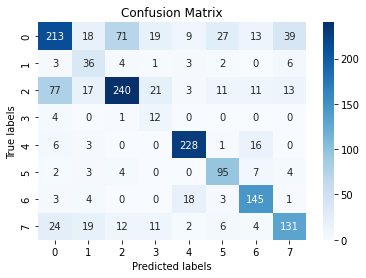

In [105]:
ax= plt.subplot()
cm = confusion_matrix(xgb_model.predict(X_test_1), y_test_1['genre'])
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [106]:
print(classification_report(xgb_model.predict(X_test_1), y_test_1['genre']))

                       precision    recall  f1-score   support

 classic pop and rock       0.64      0.52      0.57       409
dance and electronica       0.36      0.65      0.46        55
                 folk       0.72      0.61      0.66       393
       jazz and blues       0.19      0.71      0.30        17
                metal       0.87      0.90      0.88       254
                  pop       0.66      0.83      0.73       115
                 punk       0.74      0.83      0.78       174
      soul and reggae       0.68      0.63      0.65       209

             accuracy                           0.68      1626
            macro avg       0.61      0.71      0.63      1626
         weighted avg       0.70      0.68      0.68      1626



In [107]:
print(cohen_kappa_score(xgb_model.predict(X_test_1), y_test_1['genre']))

0.6135039272049264


In [108]:
## for test predition
# prepare for numeric and text data
test = combine_title_and_tags(test)
X_test_num = create_pca_lda_for_test(test, vect_col)
X_test_num2 = create_new_features(X_test_num)


(428, 173)

In [111]:
X_test_num2 = X_test_num2.drop(columns=['text'])

In [112]:

X_test_text_array1, _ = prepare_text_for_prediction(test, np.nan, train_id2word,lda_model)
X_test_text_array2, _ = prepare_text_for_prediction(test, np.nan, train_id2word,lda_model2)
final_test_vecs=np.concatenate( [X_test_text_array1, X_test_text_array2], axis=1)
X_final_feature = np.concatenate([final_test_vecs,np.array(X_test_num2[num_pred_col])],axis=1)

In [113]:
np.shape(X_final_feature)

(428, 190)

In [41]:
np.shape(valid_vecs), np.shape(final_test_vecs)

((3252, 18), (428, 18))

In [117]:
pd.DataFrame(xgb_model.predict(X_final_feature),columns=['predictions']).to_csv('predictions/prediction.csv')

In [9]:
np.shape(X_test_text_array2), np.shape(final_test_vecs)

((428, 9), (428, 18))